# Try writing own mapper

In [1]:
from __future__ import annotations

from functools import lru_cache

import numpy as np

from qiskit.quantum_info.operators import Pauli

from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper

## Build up problem

In [2]:
# imports
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

from qiskit_algorithms import AdaptVQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

In [3]:
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto-3g")
problem = driver.run()

In [4]:
print(f"Num particles: {problem.num_particles}")
print(f"Num orbitals: {problem.num_spatial_orbitals}")

Num particles: (1, 1)
Num orbitals: 2


## Integrate code for optimizing Majorana

In [5]:
%load_ext autoreload
%autoreload 2

from jordan_wigner import jw_majoranas
from electronic_hamiltonian import quadratic_terms
from qiskit.quantum_info import PauliList
from tableau import spread_node, spread_node_slice, anticommutation_matrix
import random
from cost_functions import weight, quadratic_term_mean_weight
from annealing import anneal
import matplotlib.pyplot as plt

In [6]:
N = problem.num_spatial_orbitals*2

x, z = jw_majoranas(N)

paulis = PauliList.from_symplectic(z, x)

print("Majorana Operators:", paulis)

x_terms, z_terms = quadratic_terms(x, z, N)

quadratic_terms_paulis = PauliList.from_symplectic(z_terms, x_terms)

print("Quadratic Hamiltonian Terms:", quadratic_terms_paulis)

print(f"Average Weight: {weight(x, z)}")

Majorana Operators: ['IIIX', 'IIXZ', 'IXZZ', 'XZZZ', 'IIIY', 'IIYZ', 'IYZZ', 'YZZZ']
Quadratic Hamiltonian Terms: ['IIXY', 'IXZY', 'XZZY', 'IXYI', 'XZYI', 'XYII']
Average Weight: 20


Initial temperature T0 = 0.0833
Iteration 4: New optimal energy = 2.500000
Iteration 5: New optimal energy = 2.166667
Iteration 11: New optimal energy = 1.500000


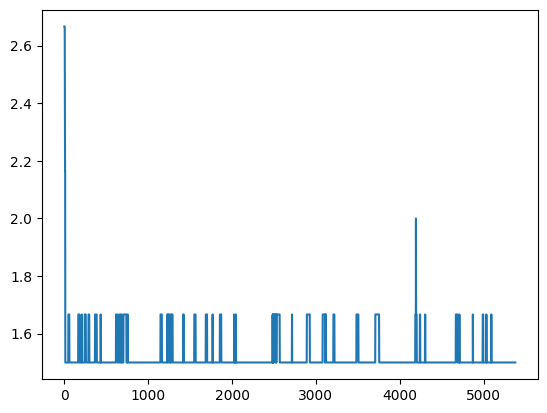

In [7]:
x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.99995)

paulis = PauliList.from_symplectic(z, x)

plt.plot(energies)

In [8]:
print(paulis)

['IYZZ', 'IYZX', 'IYZY', 'IYYI', 'IZII', 'IYXI', 'XXII', 'YXII']


## Implement my OwnMapper

In [9]:
"""The My-Own Mapper. """

class MyOwnMapper(FermionicMapper):
    """The Jordan-Wigner fermion-to-qubit mapping."""

    @classmethod
    @lru_cache(maxsize=32)
    def pauli_table(cls, register_length: int) -> list[tuple[Pauli, Pauli]]:
        # pylint: disable=unused-argument
        pauli_table = []

        #for i in range(register_length):
            #a_z = np.asarray([1] * i + [0] + [0] * (register_length - i - 1), dtype=bool)
            #a_x = np.asarray([0] * i + [1] + [0] * (register_length - i - 1), dtype=bool)
            #b_z = np.asarray([1] * i + [1] + [0] * (register_length - i - 1), dtype=bool)
            #b_x = np.asarray([0] * i + [1] + [0] * (register_length - i - 1), dtype=bool)
            # c_z = np.asarray([0] * i + [1] + [0] * (register_length - i - 1), dtype=bool)
            # c_x = np.asarray([0] * register_length, dtype=bool)
            #pauli_table.append((Pauli((a_z, a_x)), Pauli((b_z, b_x))))
            # TODO add Pauli 3-tuple to lookup table

        for i in range(int(len(paulis)//2)):
            pauli_table.append((paulis[i], paulis[int(len(paulis)//2+i)]))

        
        #pauli_table = paulis.copy()

        print(pauli_table)

        # PauliList has the phase information.
        # Here, phase is unnecessary, so the following removes phase.
        for pauli1, pauli2 in pauli_table:
            pauli1.phase = 0
            pauli2.phase = 0
        return pauli_table

## Test My Own Mapper

In [10]:
mappers = {}
mappers["JW"] = JordanWignerMapper()
mappers["Own"] = MyOwnMapper()
mappers["Bravi-Kitaev"] = BravyiKitaevMapper()

In [11]:
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [12]:
for key in mappers.keys():
    print(f"Generating ansatz, vqe, and adapt-vqe for: {key}")
    qubit_op = mappers[key].map(problem.second_q_ops()[0])
    
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mappers[key],
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mappers[key],
        ),
    )

    print(HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mappers[key],
        ))
    
    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        
    vqe = VQE(Estimator(), ansatz, SLSQP(), callback=store_intermediate_result)
    vqe.initial_point = np.zeros(ansatz.num_parameters)
    
    adapt_vqe = AdaptVQE(vqe)
    adapt_vqe.supports_aux_operators = lambda: True  # temporary fix

    print(f"\tANSATZ: Count-Ops: {ansatz.decompose().decompose().decompose().count_ops()} size: {ansatz.decompose().decompose().decompose().size()} depth = {ansatz.decompose().decompose().decompose().depth()}")
    print(f"\tqubit-op: {qubit_op}")
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    print(vqe_calc)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    result = exact_solver(qubit_op, problem)

    print(f"Total ground state energy(vqe) = {vqe_result:.4f}")
    print(f"Total ground state energy(exact) = {result.total_energies[0].real:.4f}")

    print(counts)
    print(values)

Generating ansatz, vqe, and adapt-vqe for: JW
     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          
	ANSATZ: Count-Ops: OrderedDict([('h', 80), ('cx', 56), ('sdg', 20), ('s', 20), ('rz', 12), ('u', 2)]) size: 190 depth = 97
	qubit-op: SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])
{   'aux_operators_evaluated': None,
    'cost_function_evals': 10,
    'eigenvalue': -1.8572750301432643,
    'optimal_circuit': <qiskit_nature.second_q.circuit.library.ansatzes.uccsd.UCCSD object at 0x7f962b001d50>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): 8.484831330573803e-08,
  